In [ ]:
import os
os.chdir('./../')

In [5]:
import scanpy as sc
from compert.train import prepare_compert
from compert.api import ComPertAPI
from sklearn.metrics import r2_score
import torch
import pandas as pd

In [3]:
# adata = sc.read('datasets/sciplex3_new.h5ad')
adata = sc.read('datasets/sciplex3_old_reproduced.h5ad')

In [ ]:
import os
directory = './results_last_h2/results_last/'
r2_mean_dict = {}
r2_var_dict = {}
r2_mean_deg_dict = {}
r2_var_deg_dict = {}
for filename in os.listdir(directory):
    if filename.endswith(".pt"):
        dict_key = filename.split('_')[4]
        print(dict_key)
        state, args, history = torch.load(
            os.path.join(directory, filename),
            map_location=torch.device('cpu')
        )
        model, datasets = prepare_compert(args, state_dict=state)
        
        compert_api = ComPertAPI(datasets, model)
        
        genes_control = adata[adata.obs[args['perturbation_key']] == 'control'].copy()
        sc.pp.subsample(genes_control, n_obs=1000)
        df = pd.DataFrame(
            {
                args['perturbation_key']: pd.Series(
                    pd.Series(datasets['ood'].pert_categories).unique()).apply(lambda x: x.split('_')[1]), 
                args['dose_key']: pd.Series(
                    pd.Series(datasets['ood'].pert_categories).unique()).apply(lambda x: x.split('_')[2]), 
                args['cell_type_key']: pd.Series(
                    pd.Series(datasets['ood'].pert_categories).unique()).apply(lambda x: x.split('_')[0])
            }                                                                                           
        )

        pred = compert_api.predict(genes_control.X.toarray(), df, return_anndata=True)  # normally would put `sample=True` here
        pred.obs['cov_drug_dose_name'] = \
            pred.obs['cell_type'].astype(str) + '_' + pred.obs['condition'].astype(str) + '_' + pred.obs['dose_val'].astype(str)
        pred.obs['cov_drug_dose_name'] = pred.obs['cov_drug_dose_name'].astype('category')
        print(pred)
        de_genes = datasets['ood'].de_genes
        r2s_mean = {}
        r2s_var = {}
        r2s_mean_deg = {}
        r2s_var_deg = {}
        conditions = pred.obs['cov_drug_dose_name'].cat.categories
        for cond in conditions:
            degs = de_genes[cond]
            y_pred_deg = pred[:, degs][pred.obs['cov_drug_dose_name'] == cond].X
            y_true_adata_deg = adata[:, degs]
            y_pred = pred[pred.obs['cov_drug_dose_name'] == cond].X
            y_true_adata = adata

            y_true = y_true_adata[y_true_adata.obs['cov_drug_dose_name'] ==\
                cond].X.toarray()
            y_true_deg = y_true_adata_deg[y_true_adata_deg.obs['cov_drug_dose_name'] ==\
                cond].X.toarray()
            
            r2s_mean[cond] = (r2_score(y_true.mean(axis=0),\
                y_pred.mean(axis=0)))
            r2s_var[cond] = (r2_score(y_true.var(axis=0),\
                y_pred.var(axis=0)))
            
            r2s_mean_deg[cond] = (r2_score(y_true_deg.mean(axis=0),\
                y_pred_deg.mean(axis=0)))
            r2s_var_deg[cond] = (r2_score(y_true_deg.var(axis=0),\
                y_pred_deg.var(axis=0)))
            
        r2_mean_dict[dict_key] = r2s_mean
        r2_var_dict[dict_key] = r2s_var
        r2_mean_deg_dict[dict_key] = r2s_mean_deg
        r2_var_deg_dict[dict_key] = r2s_var_deg

In [10]:
dfs = {}
dfs['r2_mean'] = pd.DataFrame(r2_mean_dict).reset_index()
dfs['r2_mean_deg'] = pd.DataFrame(r2_mean_deg_dict).reset_index()
dfs['r2_var'] = pd.DataFrame(r2_var_dict).reset_index()
dfs['r2_var_deg'] = pd.DataFrame(r2_var_deg_dict).reset_index()

In [12]:
for key in dfs.keys():
    dfs[key] = pd.melt(
        dfs[key], 
        id_vars='index', 
        value_vars=dfs[key].columns[dfs[key].columns.str.contains('split')]
    )
    dfs[key] = dfs[key].dropna()
    dfs[key]['dosage'] = dfs[key]['index'].apply(lambda x: x.split('_')[-1]).astype('category')
    dfs[key]['split_names'] = dfs[key]['variable'].map(adata.uns['splits'])
    dfs[key]['split_info'] = dfs[key]['split_names'].apply(lambda x: x.split('_')[0]).astype('category')
    dfs[key]['dosage'] = dfs[key]['dosage'].cat.reorder_categories(['0.001', '0.01', '0.1', '1.0'])
    dfs[key]['split_info'] = dfs[key]['split_info'].cat.reorder_categories([
        'A549', 'MCF7', 'K562', 'A549+MCF7', 'A549+K562', 'MCF7+K562', 'all'
    ])
    dfs[key].to_csv(f'{key}.csv')

[Text(0, 0, 'A549'),
 Text(1, 0, 'MCF7'),
 Text(2, 0, 'K562'),
 Text(3, 0, 'A549+MCF7'),
 Text(4, 0, 'A549+K562'),
 Text(5, 0, 'MCF7+K562'),
 Text(6, 0, 'all')]

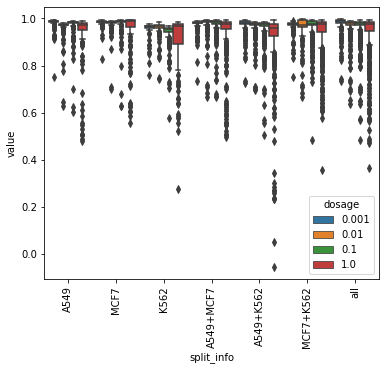

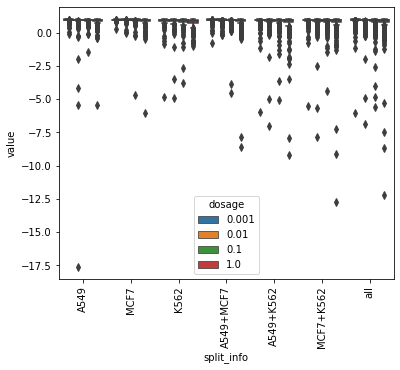

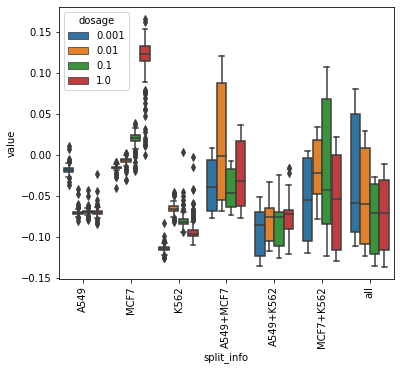

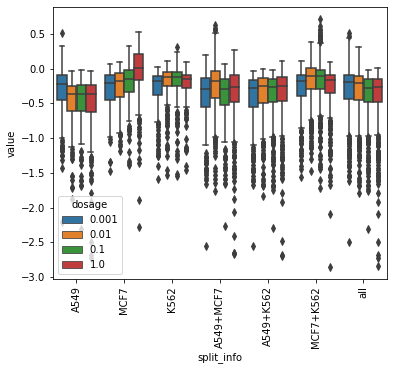

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.boxplot(x='split_info', y='value', hue='dosage', data=dfs['r2_mean'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.boxplot(x='split_info', y='value', hue='dosage', data=dfs['r2_mean_deg'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.boxplot(x='split_info', y='value', hue='dosage', data=dfs['r2_var'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.boxplot(x='split_info', y='value', hue='dosage', data=dfs['r2_var_deg'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Text(0.5, 1.0, 'OOD R2 DEG')

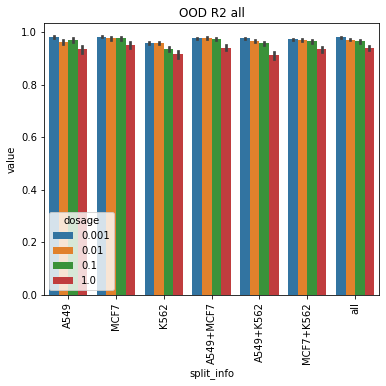

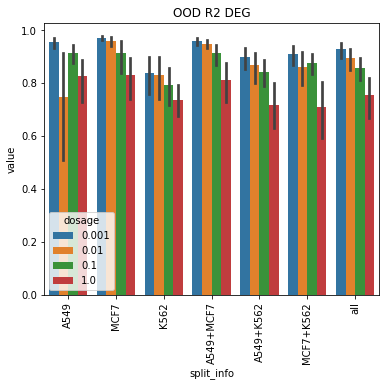

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.barplot(x='split_info', y='value', hue='dosage', data=dfs['r2_mean'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('OOD R2 all')
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.barplot(x='split_info', y='value', hue='dosage', data=dfs['r2_mean_deg'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('OOD R2 DEG')